# Utilizzo della libreria Backtester

Questo notebook mostra come utilizzare la libreria di backtesting che abbiamo creato per testare strategie di trading con le Bollinger Bands.

## 1. Importazione delle librerie

In [1]:
# Importa i moduli della libreria backtester
import sys
sys.path.append('/home/edocame/Desktop/bollingerBands')  # Aggiungi il path

from modules.backtester import data_loader, indicators, backtest_engine, visualization, utils
import pandas as pd
import numpy as np

# Importa anche matplotlib per i grafici
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Caricamento e preparazione dei dati

In [2]:
# Carica i dati tick dal file Parquet
file_path = '/home/edocame/Desktop/data_python/03_BID_ASK_DATA/EURCHF_oanda_alltime.parquet'
tick_data = data_loader.load_parquet_data(file_path)

print(f"Dati caricati: {len(tick_data)} righe")
print(f"Periodo: {tick_data.index.min()} - {tick_data.index.max()}")
print(f"Colonne: {tick_data.columns.tolist()}")
print("\nPrime righe:")
print(tick_data.head())

Dati caricati: 378784726 righe
Periodo: 0 - 378784725
Colonne: ['datetime', 'bid', 'ask']

Prime righe:
                 datetime      bid      ask
0 2003-08-04 03:00:03.491  1.53844  1.53854
1 2003-08-04 03:00:36.109  1.53820  1.53845
2 2003-08-04 03:00:36.301  1.53834  1.53859
3 2003-08-04 03:00:46.305  1.53822  1.53832
4 2003-08-04 03:00:46.497  1.53838  1.53848


In [3]:
# Assicurati che la colonna 'datetime' sia di tipo datetime e impostala come indice
if not pd.api.types.is_datetime64_any_dtype(tick_data['datetime']):
    tick_data['datetime'] = pd.to_datetime(tick_data['datetime'], errors='coerce')
    print('Colonna datetime convertita in datetime.')
else:
    print('Colonna datetime già in formato datetime.')

# Imposta la colonna 'datetime' come indice
if tick_data.index.name != 'datetime':
    tick_data = tick_data.set_index('datetime')
    print('Colonna datetime impostata come indice.')
else:
    print('Colonna datetime già impostata come indice.')

# Mostra le prime righe per conferma
print(tick_data.head())

Colonna datetime già in formato datetime.
Colonna datetime impostata come indice.
                             bid      ask
datetime                                 
2003-08-04 03:00:03.491  1.53844  1.53854
2003-08-04 03:00:36.109  1.53820  1.53845
2003-08-04 03:00:36.301  1.53834  1.53859
2003-08-04 03:00:46.305  1.53822  1.53832
2003-08-04 03:00:46.497  1.53838  1.53848


In [4]:
# Prepara i dati a minuto
minute_data = data_loader.prepare_minute_data(tick_data, resample_rule='1T')

print(f"Dati a minuto: {len(minute_data)} righe")
print(f"Periodo: {minute_data.index.min()} - {minute_data.index.max()}")
print("\nPrime righe:")
print(minute_data.head())

/home/edocame/Desktop/bollingerBands/modules/backtester/data_loader.py:96: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  minute_sample = tick_data.resample(resample_rule).agg({'bid': 'first', 'ask': 'first'})


Dati a minuto: 8182527 righe
Periodo: 2003-08-04 03:00:00 - 2025-07-11 23:59:00

Prime righe:
                         bid      ask  midprice
datetime                                       
2003-08-04 03:00:00  1.53844  1.53854   1.53849
2003-08-04 03:01:00  1.53803  1.53823   1.53813
2003-08-04 03:02:00  1.53777  1.53801   1.53789
2003-08-04 03:03:00  1.53772  1.53796   1.53784
2003-08-04 03:04:00  1.53764  1.53774   1.53769


## 3. Calcolo degli indicatori tecnici

In [ ]:
# Calcola le Bollinger Bands
window = 1440  # 24 ore = 1440 minuti
num_std_dev = 1.0

data_with_bands = indicators.bollinger_bands(
    minute_data, 
    price_column='midprice',
    window=window, 
    num_std_dev=num_std_dev
)

# Rimuovi le righe con valori NaN
complete_data = data_with_bands.dropna()

print(f"Dati completi per il backtest: {len(complete_data)} righe")
print(f"Colonne disponibili: {complete_data.columns.tolist()}")
print("\nPrime righe con indicatori:")
print(complete_data.head())

## 4. Esecuzione del backtest

In [ ]:
# Crea e esegui il backtest
backtester = backtest_engine.Backtest(complete_data)
results_data = backtester.run()

# Stampa il riassunto delle performance
backtester.print_performance_summary()

## 5. Analisi dei risultati

In [ ]:
# Ottieni i risultati come DataFrame
trades_df = backtester.get_trades_dataframe()

if not trades_df.empty:
    print(f"Numero di trade: {len(trades_df)}")
    print("\nPrimi 10 trade:")
    print(trades_df.head(10))
    
    # Statistiche aggiuntive
    win_loss_stats = utils.calculate_win_loss_ratio(trades_df['PnL'])
    print("\nStatistiche Win/Loss:")
    for key, value in win_loss_stats.items():
        print(f"  {key}: {value:.2f}")
else:
    print("Nessun trade eseguito.")

## 6. Visualizzazione dei risultati

In [ ]:
# Visualizza i prezzi con le Bollinger Bands
# Prendi un subset dei dati per una visualizzazione più chiara
subset_data = complete_data.iloc[-2000:]  # Ultimi 2000 punti

visualization.plot_price_with_bollinger_bands(
    subset_data, 
    title="EURCHF con Bollinger Bands (ultimi 2000 punti)"
)

In [ ]:
# Visualizza il PnL cumulativo
if not trades_df.empty:
    visualization.plot_cumulative_pnl(
        trades_df, 
        title="PnL Cumulativo - Strategia Bollinger Bands"
    )

In [ ]:
# Visualizza la distribuzione dei trade
if not trades_df.empty:
    visualization.plot_trade_distribution(
        trades_df, 
        title="Distribuzione PnL dei Trade"
    )

## 7. Grafici interattivi (Plotly)

In [ ]:
# Grafico interattivo dei prezzi con Bollinger Bands
visualization.plot_interactive_price_bands(
    subset_data, 
    title="EURCHF con Bollinger Bands - Grafico Interattivo"
)

In [ ]:
# Grafico interattivo del PnL cumulativo
if not trades_df.empty:
    visualization.plot_interactive_cumulative_pnl(
        trades_df, 
        title="PnL Cumulativo - Grafico Interattivo"
    )

## 8. Confronto con dati reali (se disponibili)

In [ ]:
# Carica i dati di balance reali per confronto
try:
    balance_file = '/home/edocame/Desktop/bollingerBands/DATA/eurchf_1440_01.csv'
    balance_data = data_loader.load_balance_data(balance_file)
    
    print(f"Dati balance caricati: {len(balance_data)} righe")
    print(f"Periodo balance: {balance_data.index.min()} - {balance_data.index.max()}")
    
    # Confronta con i risultati del backtest
    if not trades_df.empty:
        # Trova il periodo comune tra backtest e balance
        # Assumiamo che trades_df abbia una colonna 'Exit_Time' con i timestamp
        if 'Exit_Time' in trades_df.columns:
            backtest_start = trades_df['Exit_Time'].min()
            backtest_end = trades_df['Exit_Time'].max()
        else:
            # Se non c'è Exit_Time, usa l'indice del DataFrame completo
            backtest_start = complete_data.index.min()
            backtest_end = complete_data.index.max()
        
        balance_start = balance_data.index.min()
        balance_end = balance_data.index.max()
        
        # Calcola il periodo comune
        common_start = max(backtest_start, balance_start)
        common_end = min(backtest_end, balance_end)
        
        print(f"\nPeriodo backtest: {backtest_start} - {backtest_end}")
        print(f"Periodo balance: {balance_start} - {balance_end}")
        print(f"Periodo comune: {common_start} - {common_end}")
        
        # Verifica che esista un periodo comune
        if common_start <= common_end:
            # Filtra i dati al periodo comune
            if 'Exit_Time' in trades_df.columns:
                trades_common = trades_df[
                    (trades_df['Exit_Time'] >= common_start) & 
                    (trades_df['Exit_Time'] <= common_end)
                ]
            else:
                # Se non c'è Exit_Time, crea un dataset filtrato basato sui timestamp
                trades_common = trades_df.copy()
                
            balance_common = balance_data.loc[common_start:common_end]
            
            print(f"\nTrade nel periodo comune: {len(trades_common)}")
            print(f"Righe balance nel periodo comune: {len(balance_common)}")
            
            # Crea il grafico di confronto solo per il periodo comune
            if len(trades_common) > 0 and len(balance_common) > 0:
                visualization.compare_backtest_vs_real_balance(
                    trades_common, 
                    balance_common, 
                    title=f"Confronto: Backtest vs Balance Reale ({common_start.strftime('%Y-%m-%d')} - {common_end.strftime('%Y-%m-%d')})"
                )
                
                # Mostra anche alcune statistiche di confronto
                print(f"\n=== STATISTICHE PERIODO COMUNE ===")
                print(f"PnL finale backtest: {trades_common['Cumulative_PnL'].iloc[-1]:.2f} pips")
                print(f"Balance finale reale: {balance_common['<BALANCE>'].iloc[-1]:.2f}")
                
                # Calcola la correlazione se possibile
                if len(trades_common) > 1 and len(balance_common) > 1:
                    # Resample per allineare le frequenze
                    try:
                        balance_daily = balance_common['<BALANCE>'].resample('D').last().dropna()
                        trades_daily = trades_common.set_index('Exit_Time')['Cumulative_PnL'].resample('D').last().dropna()
                        
                        # Trova l'intersezione delle date
                        common_dates = balance_daily.index.intersection(trades_daily.index)
                        
                        if len(common_dates) > 2:
                            corr = balance_daily.loc[common_dates].corr(trades_daily.loc[common_dates])
                            print(f"Correlazione giornaliera: {corr:.3f}")
                        else:
                            print("Insufficienti dati per calcolare la correlazione")
                    except Exception as e:
                        print(f"Errore nel calcolo della correlazione: {e}")
            else:
                print("ERRORE: Nessun dato disponibile nel periodo comune filtrato")
        else:
            print("ERRORE: Non ci sono date in comune tra backtest e balance!")
    else:
        print("Nessun trade disponibile per il confronto")
        
except Exception as e:
    print(f"Errore nel caricamento dei dati balance: {e}")

## 9. Dashboard completo

In [ ]:
# Crea un dashboard completo con tutti i grafici
if not trades_df.empty:
    visualization.create_performance_dashboard(
        subset_data, 
        trades_df, 
        backtester.performance_metrics
    )

## 10. Test con parametri diversi

In [ ]:
# Forza il reload del modulo per assicurarsi che le nuove funzioni siano disponibili
import importlib
import sys

# Reload del modulo backtest_engine per caricare le nuove funzioni
if 'backtester.backtest_engine' in sys.modules:
    importlib.reload(sys.modules['backtester.backtest_engine'])

# Importa le funzioni di ottimizzazione dal backtest_engine
from modules.backtester.backtest_engine import optimize_parameters, plot_top_equity_curves

# Esegui l'ottimizzazione dei parametri con multiprocessing
print("Avvio ottimizzazione parametri...")
parameter_results = optimize_parameters(
    minute_data=minute_data,
    window_start=60,
    window_stop=14400,
    window_step=60,
    std_start=0.2,
    std_stop=4.0,
    std_step=0.2,
    price_column='midprice'
)

# Mostra i risultati completi
print("\n=== TUTTI I RISULTATI ===")
print(parameter_results.to_string(index=False))

# Plotta le top 5 equity curves usando la funzione dedicata
print("\nGenerazione grafici delle migliori equity curves...")
plot_top_equity_curves(
    results_df=parameter_results,
    minute_data=minute_data,
    top_n=5,
    price_column='midprice'
)

## Walk forward opt

In [5]:
# Crea un subset di minute_data in base a start_date e end_date
start_date = '2023-01-01'
end_date = '2024-01-31'
subset_df = minute_data.loc[start_date:end_date]

print(f"Subset creato: {len(subset_df)} righe")
print(f"Periodo: {subset_df.index.min()} - {subset_df.index.max()}")
print(subset_df.head())

Subset creato: 400739 righe
Periodo: 2023-01-02 00:42:00 - 2024-01-31 23:59:00
                         bid      ask  midprice
datetime                                       
2023-01-02 00:42:00  0.98520  0.98688  0.986040
2023-01-02 01:15:00  0.98607  0.98889  0.987480
2023-01-02 01:16:00  0.98610  0.98891  0.987505
2023-01-02 01:17:00  0.98609  0.98890  0.987495
2023-01-02 01:18:00  0.98610  0.98891  0.987505


Starting Walk Forward Optimization...
=== WALK FORWARD OPTIMIZATION ===
Lookback period: 30 days (43200 minutes)
Optimization interval: 30 days
Total data period: 2023-01-02 00:42:00 to 2024-01-31 23:59:00

--- Period 1 ---
Optimization: 2023-01-02 00:42:00 to 2023-02-13 08:16:00
Trading: 2023-02-13 08:17:00 to 2023-03-27 13:41:00
Starting optimization with 18 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization:   0%|          | 0/18 [00:00<?, ?it/s]

Parameter optimization: 100%|██████████| 18/18 [00:01<00:00, 17.30it/s]



Optimal parameters: window=400, std_dev=3.0
Period 1 results: PnL=-58.30 pips, Trades=75, Win Rate=57.3%

--- Period 2 ---
Optimization: 2023-02-13 08:17:00 to 2023-03-27 13:41:00
Trading: 2023-03-27 13:42:00 to 2023-05-08 17:55:00
Starting optimization with 18 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 18/18 [00:00<00:00, 137.41it/s]


Optimal parameters: window=600, std_dev=3.0
Period 2 results: PnL=-46.70 pips, Trades=50, Win Rate=70.0%

--- Period 3 ---
Optimization: 2023-03-27 13:42:00 to 2023-05-08 17:55:00
Trading: 2023-05-08 17:56:00 to 2023-06-19 23:31:00
Starting optimization with 18 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 18/18 [00:00<00:00, 188.09it/s]


Optimal parameters: window=600, std_dev=3.0
Period 3 results: PnL=91.20 pips, Trades=62, Win Rate=75.8%

--- Period 4 ---
Optimization: 2023-05-08 17:56:00 to 2023-06-19 23:31:00
Trading: 2023-06-19 23:32:00 to 2023-08-01 07:37:00
Starting optimization with 18 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 18/18 [00:00<00:00, 198.25it/s]


Optimal parameters: window=600, std_dev=2.5
Period 4 results: PnL=-47.80 pips, Trades=73, Win Rate=68.5%

--- Period 5 ---
Optimization: 2023-06-19 23:32:00 to 2023-08-01 07:37:00
Trading: 2023-08-01 07:38:00 to 2023-09-12 16:09:00
Starting optimization with 18 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 18/18 [00:00<00:00, 197.92it/s]


Optimal parameters: window=500, std_dev=3.0
Period 5 results: PnL=-59.60 pips, Trades=56, Win Rate=66.1%

--- Period 6 ---
Optimization: 2023-08-01 07:38:00 to 2023-09-12 16:09:00
Trading: 2023-09-12 16:10:00 to 2023-10-25 00:29:00
Starting optimization with 18 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 18/18 [00:00<00:00, 195.60it/s]


Optimal parameters: window=500, std_dev=2.5
Period 6 results: PnL=8.50 pips, Trades=94, Win Rate=73.4%

--- Period 7 ---
Optimization: 2023-09-12 16:10:00 to 2023-10-25 00:29:00
Trading: 2023-10-25 00:30:00 to 2023-12-06 08:49:00
Starting optimization with 18 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 18/18 [00:00<00:00, 194.72it/s]


Optimal parameters: window=600, std_dev=1.5
Period 7 results: PnL=-205.10 pips, Trades=119, Win Rate=71.4%

--- Period 8 ---
Optimization: 2023-10-25 00:30:00 to 2023-12-06 08:49:00
Trading: 2023-12-06 08:50:00 to 2024-01-19 15:23:00
Starting optimization with 18 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 18/18 [00:00<00:00, 156.71it/s]



Optimal parameters: window=500, std_dev=3.0
Period 8 results: PnL=72.20 pips, Trades=66, Win Rate=74.2%


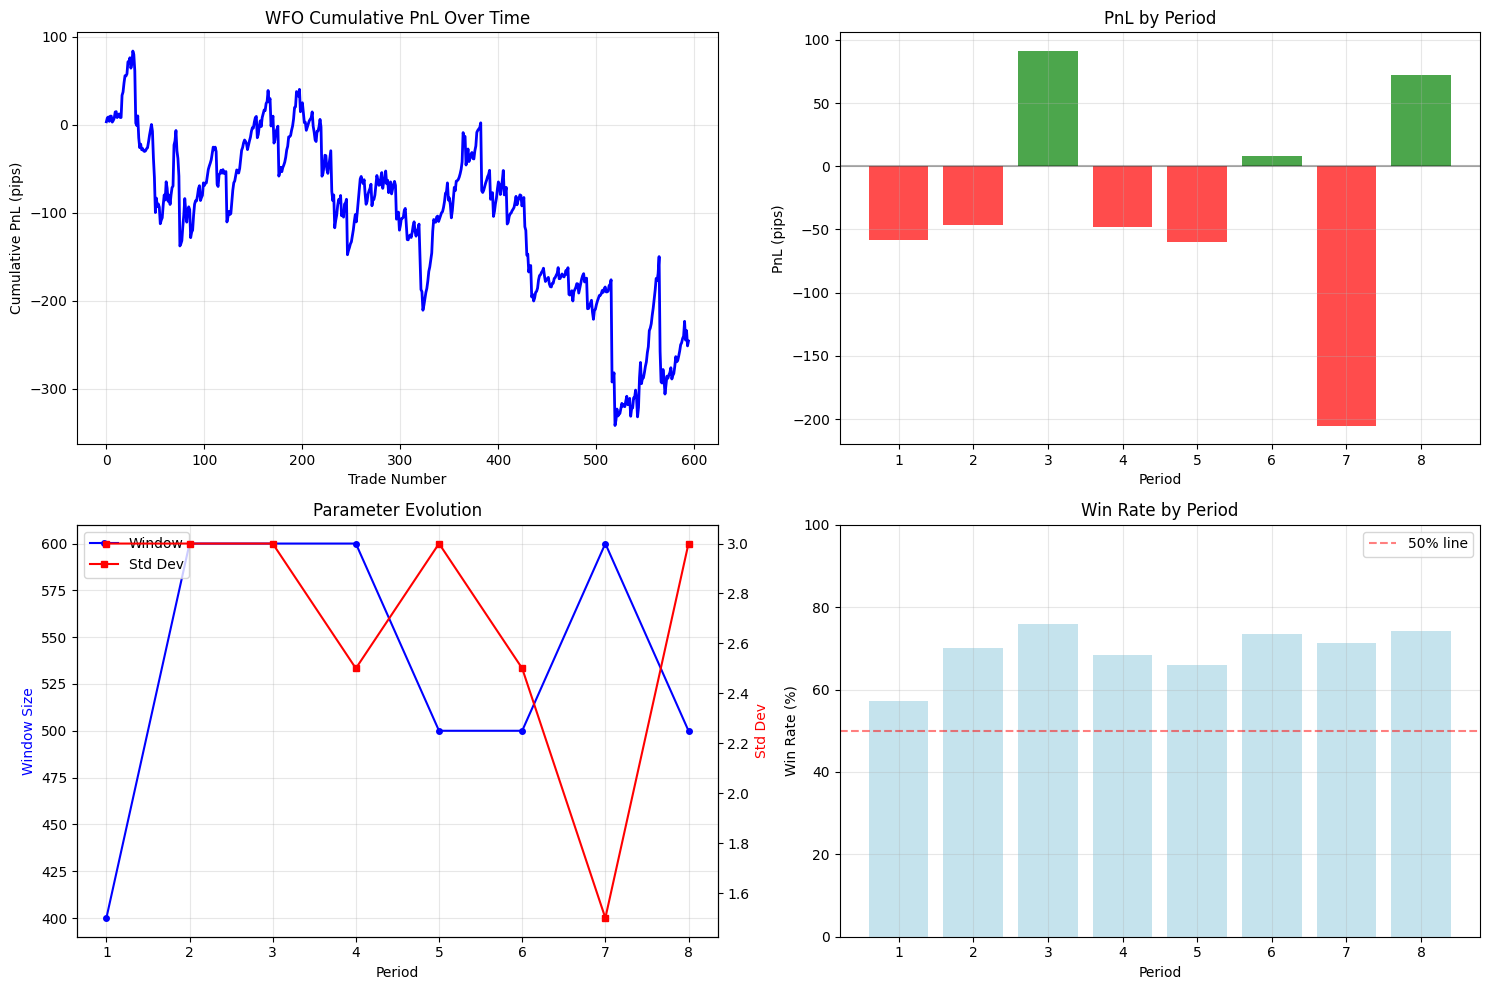


=== WALK FORWARD OPTIMIZATION SUMMARY ===
Total Periods: 8
Total PnL: -245.60 pips
Total Trades: 595
Winning Trades: 415
Losing Trades: 178
Win Rate: 69.75%
Max Drawdown: 425.20 pips
Average PnL per Period: -30.70 pips
Average PnL per Trade: -0.41 pips


In [9]:
# Force reload of the modules to ensure latest changes are loaded
import importlib
import sys

# Reload all backtester modules
modules_to_reload = [
    'modules.backtester.walk_forward',
    'modules.backtester.backtest_engine',
    'modules.backtester.indicators',
    'modules.backtester.data_loader',
    'modules.backtester.visualization',
    'modules.backtester.utils'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

# Re-import the walk forward functions with the fixes
from modules.backtester.walk_forward import walk_forward_optimization, plot_wfo_results

# Execute Walk Forward Optimization with proper error handling
try:
    print("Starting Walk Forward Optimization...")
    wfo_results = walk_forward_optimization(
        minute_data=subset_df,
        lookback_days=30,  # Use 30 days of data for optimization
        optimization_interval_days=30,  # Re-optimize every 30 days
        window_start=400,
        window_stop=600,
        window_step=100,
        std_start=0.5,
        std_stop=3.0,
        std_step=0.5,
        price_column='midprice'
    )
    
    # Plot and analyze results
    plot_wfo_results(wfo_results)
    
except Exception as e:
    print(f"Error during Walk Forward Optimization: {e}")
    import traceback
    traceback.print_exc()
    print("Please check your data and parameters.")